Gmap plugin for Jupyter required to run notebook. See https://jupyter-gmaps.readthedocs.io/en/latest/index.html for installation instructions. Once installed, get an API key from Google at https://developers.google.com/maps/documentation/geocoding/get-api-key. Once this is done, run the following command in terminal and restart jupyter:

jupyter nbextension enable --py gmaps

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gmaps
import seaborn as sbn
import requests
import time
import math
%matplotlib inline

In [2]:
# Read Google API Key
GOOGLE_API_KEY = None
with open('apikey.txt') as f:
    GOOGLE_API_KEY = f.readline()
    f.close

In [3]:
gmaps.configure(api_key=GOOGLE_API_KEY) # Google API key goes here

In [4]:
new_york_coordinates = (40.75, -74.00)

In [5]:
df = pd.read_csv('analyze_me.csv')

First, call df.info() to get a high level overview about the dataset. From the call we see that 7 out of the 18 columns in the dataset contain missing values. These fields are:
- place_category
- item_name
- item_quantity
- item_category_name
- how_long_it_took_to_order
- when_the_Jumpman_arrived_at_pickup
- when_the_Jumpman_arrived_at_dropoff

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5983 entries, 0 to 5982
Data columns (total 18 columns):
delivery_id                            5983 non-null int64
customer_id                            5983 non-null int64
jumpman_id                             5983 non-null int64
vehicle_type                           5983 non-null object
pickup_place                           5983 non-null object
place_category                         5100 non-null object
item_name                              4753 non-null object
item_quantity                          4753 non-null float64
item_category_name                     4753 non-null object
how_long_it_took_to_order              3038 non-null object
pickup_lat                             5983 non-null float64
pickup_lon                             5983 non-null float64
dropoff_lat                            5983 non-null float64
dropoff_lon                            5983 non-null float64
when_the_delivery_started              5983 non-nul

Convert the date fields in the dataset to datetime objects

In [7]:
df.when_the_delivery_started = pd.to_datetime(df.when_the_delivery_started)
df.when_the_Jumpman_arrived_at_dropoff = pd.to_datetime(df.when_the_Jumpman_arrived_at_dropoff)
df.when_the_Jumpman_arrived_at_pickup = pd.to_datetime(df.when_the_Jumpman_arrived_at_pickup)
df.when_the_Jumpman_left_pickup = pd.to_datetime(df.when_the_Jumpman_left_pickup)

Convert order time to timedelta object

In [8]:
df.how_long_it_took_to_order = pd.to_timedelta(df.how_long_it_took_to_order)

Let's do some quick spot checking of the pickup and drop off lat lon coordinates. There should not be any places outside of New York City. Let's verify this 

In [9]:
print(df[(df.pickup_lat > 42) | (df.pickup_lat < 40)].shape)
print(df[(df.pickup_lon < -75) | (df.pickup_lon > -72)].shape)
print(df[(df.dropoff_lat > 42) | (df.dropoff_lat < 40)].shape)
print(df[(df.dropoff_lon < -75) | (df.dropoff_lon > -72)].shape)

(0, 18)
(0, 18)
(0, 18)
(0, 18)


Based on my understanding of the problem, the order of events for purchase and delivery of products goes like this:
1. delivery starts following request by customer
2. jumpman arrives at pickup location and orders item(s)
3. jumpman leaves the pickup location
4. jumpman arrives at customer location and drop off item

Inspect the timestamps of the date fields to make sure this order is enforced. Any rows that do not follow this order is indicative of a data integrity issue.

In [10]:
date_columns = ['when_the_delivery_started','when_the_Jumpman_arrived_at_pickup',
                'when_the_Jumpman_left_pickup','when_the_Jumpman_arrived_at_dropoff']

In [11]:
for i in range(len(date_columns)):
    cola = date_columns[i]
    for j in range(i+1, len(date_columns)):
        colb = date_columns[j]
        sze = df[df[cola] > df[colb]].shape[0]
        print("# of rows {0} > {1}: {2}".format(cola, colb, sze))

# of rows when_the_delivery_started > when_the_Jumpman_arrived_at_pickup: 501
# of rows when_the_delivery_started > when_the_Jumpman_left_pickup: 2
# of rows when_the_delivery_started > when_the_Jumpman_arrived_at_dropoff: 0
# of rows when_the_Jumpman_arrived_at_pickup > when_the_Jumpman_left_pickup: 0
# of rows when_the_Jumpman_arrived_at_pickup > when_the_Jumpman_arrived_at_dropoff: 0
# of rows when_the_Jumpman_left_pickup > when_the_Jumpman_arrived_at_dropoff: 0


So 503 rows have data integrity issues. The delivery start and pickup arrival timestamps are not consistent with the other rows in the dataset. These inconistency will impact our ability to properly measure the delivery times for items. 

Are these integrity issues specific to a few jumpmen or are they indicative of a much larger issue? 

In [12]:
bad_data = df[(df.when_the_delivery_started > df.when_the_Jumpman_arrived_at_pickup) | (df.when_the_delivery_started > df.when_the_Jumpman_left_pickup)]

In [13]:
# What percentage of jumpman completed these orders?
bad_data.jumpman_id.unique().shape[0] / df.jumpman_id.unique().shape[0] * 100

41.69550173010381

**My Recommendation for CEO/CTO**: Investigate how these timestamps are generated. My guess is that the Jumpmen are manually recording them (perhaps in an app of some sort) as they receive, pickup, and complete order requests. It that's the case we need to make sure the jumpmen are trained on the proper procedure for time logging. The Jumpmen may also have been enterred improperly by mistake (perhaps in a rush to get the deliveries done). Roughly 42% of the jumpmen in the dataset made this error so it's a pretty big deal that this gets resolved. What might also help if they are entering this in an app is to add basic data validation functionality to the app to ensure that the dates make sense before they get stored in the Jumpman23 database.

Exclude bad data from the analysis

In [14]:
analysis_df = df[~df.index.isin(bad_data.index)].copy()

**Volume Metrics**

We'll create some fields we can use to produce metrics and visualizations on order volume

In [15]:
analysis_df['delivery_day'] = analysis_df.when_the_delivery_started.dt.day
analysis_df['delivery_hour'] = analysis_df.when_the_delivery_started.dt.hour
analysis_df['delivery_dayofweek'] = analysis_df.when_the_delivery_started.dt.dayofweek
analysis_df['delivery_week'] = analysis_df.when_the_delivery_started.dt.week

In [16]:
delivery_df = analysis_df[['delivery_id','delivery_hour','delivery_day',
                           'delivery_dayofweek','delivery_week','dropoff_lat',
                           'dropoff_lon','pickup_lat','pickup_lon']].drop_duplicates()

What's the average number of orders per day and per week?

In [17]:
print("Average orders per day: {:3.2f}".format(delivery_df.groupby('delivery_day')['delivery_id'].count().mean()))
print("Average orders per week: {:3.2f}".format(delivery_df.groupby('delivery_week')['delivery_id'].count().mean()))

Average orders per day: 159.20
Average orders per week: 955.20


Create plot of the average number of orders per hour.

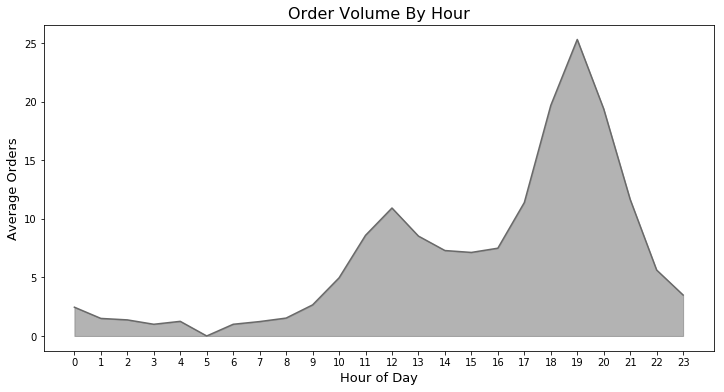

In [18]:
hourly_orders = delivery_df.groupby(['delivery_day','delivery_hour'])['delivery_id'].count().groupby('delivery_hour').mean()
for hr in range(24):
    if hr not in hourly_orders:
        hourly_orders[hr] = 0
hourly_orders = hourly_orders.sort_index()
plt.figure(figsize=(12,6))
sbn.lineplot(x = hourly_orders.index, y=hourly_orders.values, color="dimgray")
plt.fill_between(x=range(24),y1 = 0, y2=hourly_orders.values, color="dimgray",alpha=0.5)
plt.title('Order Volume By Hour',fontsize=16)
plt.xticks(range(24))
plt.xlabel('Hour of Day',fontsize=13)
plt.ylabel('Average Orders',fontsize=13);

Create of average number of orders per week

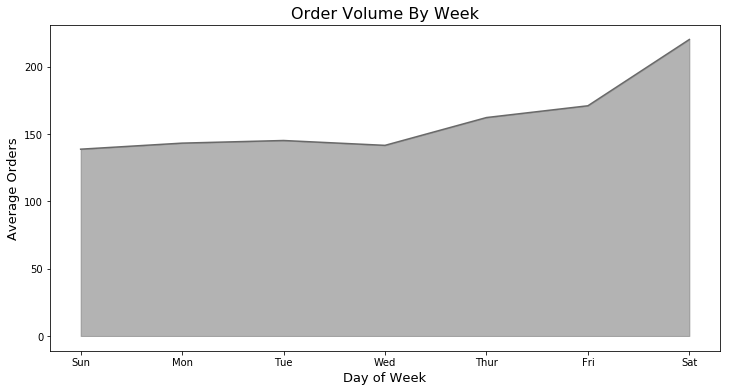

In [19]:
weekly_orders = delivery_df.groupby(['delivery_week','delivery_dayofweek'])['delivery_id'].count().groupby('delivery_dayofweek').mean()
for dy in range(7):
    if dy not in weekly_orders:
        weekly_orders[dy] = 0
weekly_orders = weekly_orders.sort_index()
plt.figure(figsize=(12,6))
sbn.lineplot(x = weekly_orders.index, y=weekly_orders.values, color="dimgray")
plt.fill_between(x=range(7),y1 = 0, y2=weekly_orders.values, color="dimgray",alpha=0.5)
plt.title('Order Volume By Week',fontsize=16)
plt.xticks(ticks=range(7),labels=['Sun','Mon','Tue','Wed','Thur','Fri','Sat'])
plt.xlabel('Day of Week',fontsize=13)
plt.ylabel('Average Orders',fontsize=13);

According to the visualizations above, peak hour for orders is 7PM EST. What's also interesting is that the order volume increase in number later in the week starting on Thursday and reaches it's peak on Saturday.

Plot a heatmap of the delivery orders by pickup location for the entire dataset. Hotspots around lower manhattan area indicates that's where a large amount of orders appear to concentrate.

In [20]:
fig = gmaps.figure(center=new_york_coordinates, zoom_level=11.9)
fig.add_layer(gmaps.heatmap_layer(delivery_df[['pickup_lat','pickup_lon']]))
fig

Figure(layout=FigureLayout(height='420px'))

**Dropoff location heatmaps**

Morning Heatmap. In the morning, deliveries are concentrated just North of Bowery

In [21]:
fig = gmaps.figure(center=new_york_coordinates, zoom_level=11.9)
fig.add_layer(gmaps.heatmap_layer(delivery_df[(delivery_df.delivery_hour >= 0) & (delivery_df.delivery_hour < 12)][['dropoff_lat','dropoff_lon']]))
fig

Figure(layout=FigureLayout(height='420px'))

Afternoon Heatmap. In the afternoon, deliveries spread out to most of Lower and Midtown Manhattan, and Chelsea.

In [22]:
fig = gmaps.figure(center=new_york_coordinates, zoom_level=11.9)
fig.add_layer(gmaps.heatmap_layer(delivery_df[(delivery_df.delivery_hour >= 12) & (delivery_df.delivery_hour < 18)][['dropoff_lat','dropoff_lon']]))
fig

Figure(layout=FigureLayout(height='420px'))

Evening Heatmap. In the evening, concentrated deliveries in small pockets in lower manhattan

In [23]:
fig = gmaps.figure(center=new_york_coordinates, zoom_level=11.9)
fig.add_layer(gmaps.heatmap_layer(delivery_df[(delivery_df.delivery_hour >= 18) & (delivery_df.delivery_hour < 24)][['dropoff_lat','dropoff_lon']]))
fig

Figure(layout=FigureLayout(height='420px'))

**Delivery Logistics**

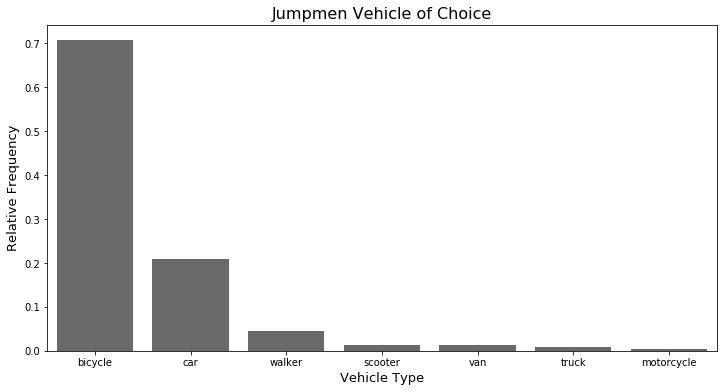

In [24]:
plt.figure(figsize=(12,6))
vehicle_df = analysis_df.vehicle_type.value_counts(normalize=True)
sbn.barplot(x=vehicle_df.index, y=vehicle_df.values, color="dimgray")
plt.title('Jumpmen Vehicle of Choice',fontsize=16)
plt.xlabel('Vehicle Type',fontsize=13)
plt.ylabel('Relative Frequency',fontsize=13);

Bicycles appear to be the Jumpmen vehicle of choice